In [1]:
# import hbsir

# The following code is written to import hbsir library from this
# repository without installation. Usually, you can import the library
# by writing "import hbsir"

import pandas as pd
from pdf2image import pdf2image

try:
    import hbsir

except ModuleNotFoundError:
    import sys
    from pathlib import Path

    for parent in Path().absolute().parents:
        if len(list(parent.glob("hbsir"))) > 0:
            hbsir_path = parent
            break
    else:
        raise FileNotFoundError

    sys.path.append(str(hbsir_path))

    import hbsir

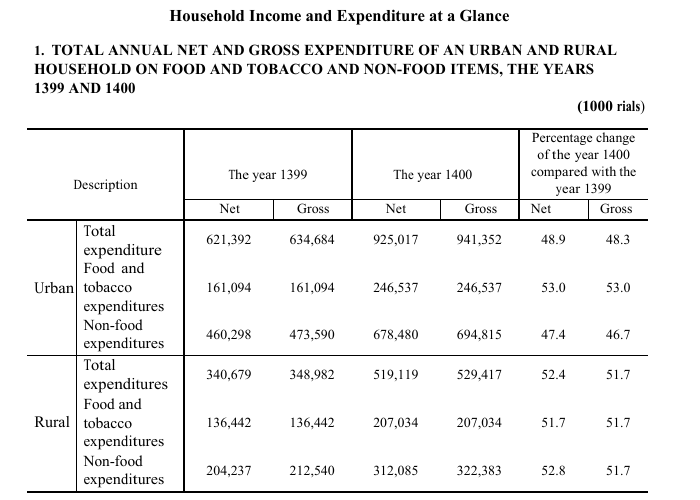

In [2]:
try:
    with open("summery-results.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests
    url = r"https://www.amar.org.ir/LinkClick.aspx?fileticket=Sxo6JC4OCi8%3d&portalid=1"
    report_file = requests.get(url)
    pdf_content = report_file.content
    with open("summery-results.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)
expenditure_summery_table = report_pages[3].crop((50, 60, 750, 560))
expenditure_summery_table

In [3]:
table = hbsir.load_table("Expenditures", [1399, 1400])
table = hbsir.add_classification(table, "Food-NonFood")
table.head(10)

,Year,ID,Code,Provision_Method,Amount,Price,Gross_Expenditure,Net_Expenditure,Food-NonFood
0,1399,10005004618,11143,Purchase,3.00,20000.0,720000.0,720000.0,Food
1,1399,10005004618,11151,Purchase,10.00,20000.0,2400000.0,2400000.0,Food
2,1399,10005004618,11164,Purchase,1.40,90000.0,1512000.0,1512000.0,Food
3,1399,10007007226,11112,Purchase,10.00,230000.0,27600000.0,27600000.0,Food
4,1399,10007007226,11151,Purchase,25.00,20000.0,6000000.0,6000000.0,Food
5,1399,10007007226,11164,Purchase,1.15,80000.0,1104000.0,1104000.0,Food
6,1399,10007007226,11212,Purchase,5.00,900000.0,54000000.0,54000000.0,Food
7,1399,10007007226,11231,Purchase,6.50,121000.0,9438000.0,9438000.0,Food
8,1399,10007007226,11412,Purchase,10.00,30000.0,3600000.0,3600000.0,Food
9,1399,10007007226,11428,Purchase,1.00,180000.0,2160000.0,2160000.0,Food


In [4]:
household_table = table.groupby(["Year", "ID", "Food-NonFood"])[["Gross_Expenditure", "Net_Expenditure"]].sum()
household_table = household_table.reset_index()
household_table = hbsir.add_weight(household_table)
household_table["Weighted_Gross_Expenditure"] = household_table.eval("Gross_Expenditure * Weight")
household_table["Weighted_Net_Expenditure"] = household_table.eval("Net_Expenditure * Weight")
household_table = hbsir.add_attribute(household_table, "Urban-Rural")
household_table.head(10)

,Year,ID,Food-NonFood,Gross_Expenditure,Net_Expenditure,Weight,Weighted_Gross_Expenditure,Weighted_Net_Expenditure,Urban-Rural
0,1399,10001000113,Food,275148000.0,275148000.0,1221.992817,3.362289e+11,3.362289e+11,Urban
1,1399,10001000113,Non-Food,862756000.0,862756000.0,1221.992817,1.054282e+12,1.054282e+12,Urban
2,1399,10001000116,Food,416628000.0,416628000.0,1221.992817,5.091164e+11,5.091164e+11,Urban
3,1399,10001000116,Non-Food,780966000.0,780966000.0,1221.992817,9.543348e+11,9.543348e+11,Urban
4,1399,10001000120,Food,362016000.0,362016000.0,1221.992817,4.423810e+11,4.423810e+11,Urban
5,1399,10001000120,Non-Food,670727000.0,670727000.0,1221.992817,8.196236e+11,8.196236e+11,Urban
6,1399,10001000123,Food,310860000.0,310860000.0,1221.992817,3.798687e+11,3.798687e+11,Urban
7,1399,10001000123,Non-Food,700516000.0,700516000.0,1221.992817,8.560255e+11,8.560255e+11,Urban
8,1399,10001000126,Food,191484000.0,191484000.0,1221.992817,2.339921e+11,2.339921e+11,Urban
9,1399,10001000126,Non-Food,300350000.0,300350000.0,1221.992817,3.670255e+11,3.670255e+11,Urban


In [5]:
weights = hbsir.load_table("Weights", years=[1399, 1400])
weights = hbsir.add_attribute(weights, "Urban-Rural")
weights_sum = weights.groupby(["Year", "Urban-Rural"])["Weight"].sum()
weights_sum

Year  Urban-Rural
1399  Rural           6127118.0
      Urban          20061995.0
1400  Rural           6135626.0
      Urban          20557988.0
Name: Weight, dtype: float64

In [6]:
summery_table = household_table.groupby(["Year", "Food-NonFood", "Urban-Rural"])[["Weighted_Net_Expenditure", "Weighted_Gross_Expenditure"]].sum()
summery_table.columns = ["Net", "Gross"]
summery_table.columns.name = "Net-Gross"
summery_table = summery_table.stack().unstack([0, 2])
summery_table = summery_table / weights_sum
summery_table = summery_table.unstack(1)
summery_table.loc["Total"] = summery_table.sum()
summery_table = summery_table.stack(1)
summery_table = summery_table.reorder_levels(["Urban-Rural", "Food-NonFood"])
summery_table = summery_table / 1000
summery_table

Year                               1399                          1400  \
Net-Gross                         Gross            Net          Gross   
Urban-Rural Food-NonFood                                                
Rural       Food          136441.741231  136441.741231  207036.586454   
Urban       Food          161094.096516  161094.096516  246537.088639   
Rural       Non-Food      212540.375490  204237.035910  322389.461074   
Urban       Non-Food      473589.564267  460297.811398  694814.393088   
Rural       Total         348982.116721  340678.777140  529426.047528   
Urban       Total         634683.660783  621391.907914  941351.481727   

Year                                     
Net-Gross                           Net  
Urban-Rural Food-NonFood                 
Rural       Food          207036.586454  
Urban       Food          246537.088639  
Rural       Non-Food      312090.109679  
Urban       Non-Food      678478.557964  
Rural       Total         519126.696133  
Urban       Total         925015.646603

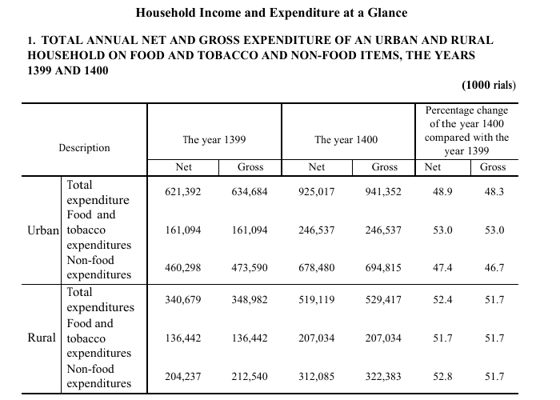

In [7]:
def sort_key(index: pd.Index, dictionary: dict):
    index = index.map(dictionary)
    index = index.astype(int)
    return index
index_order = {
    "Total": 1,
    "Food": 2,
    "Non-Food": 3,
    "Urban": 11,
    "Rural": 12,
}
column_order = {
    "Net": 1,
    "Gross": 2,
    1399: 11,
    1400: 12,
}
summery_table = summery_table.sort_index(axis="index", key=lambda i: sort_key(i, index_order))
summery_table = summery_table.sort_index(axis="columns", key=lambda i: sort_key(i, column_order))
final_df = summery_table.style.format("{:,.0f}")

image_size = expenditure_summery_table.size
scale = 0.8
new_size = tuple(int(num * scale) for num in image_size)
final_image = expenditure_summery_table.resize(new_size)

display(final_df, final_image)